In [1]:
# import modules

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import tensorflow as tf
from tensorflow import keras

# keras stuff
from keras.models import Model
from keras.models import Sequential
from keras.layers import Activation, Dense, Input, Lambda, Concatenate, add
from keras import losses, regularizers, initializers, activations
from keras import backend as K
from keras import losses as LOSS

from sklearn.model_selection import train_test_split
import os
import matplotlib.pyplot as plt

In [2]:
# # set global variables
cwd = os.getcwd()
os.chdir(cwd)

gpus = tf.config.experimental.list_physical_devices('GPU')

# Currently, memory growth needs to be the same across GPUs
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpus[0], True)
    tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)])

In [3]:
print(tf.executing_eagerly())

True


In [4]:
'''
Given no a-priori information over the Pareto set, we sample points randomly
from the feasible set. Replace this with any point distrubtion, if known.

We start with a set of 2P points, where P=50, to have equal number of
Pareto vs. non-Pareto candidates. The algorithm will move around the Pareto
candidate points towards the approximated manifold, while holding the non-Pareto
candidates in place. This gives us a d-dimensional classification surface
'''

# d=2 feature size
# sample points randomly from feasible set for current case
x = 1.*np.ndarray.flatten(np.random.rand(10,10))
y = 4.*np.ndarray.flatten(np.random.rand(10,10)-0.5)
data = np.stack([x,y], axis=1)

# split into Pareto vs. non-Pareto candidate set
fixed_data, pareto_data= train_test_split(data, test_size=0.5, random_state=42)

In [5]:
'''
HyperNet to learn the Pareto manifold. Design as per manifold complexity.
Given points from feasible set as input, this HyperNet learns an approximated
Pareto manifold over the variable domain
'''

def dense_net_pde():

    inputs = Input(shape=(2,))

    layer_1 = Dense(4, activation='tanh', use_bias=True)(inputs)
    layer_2 = Dense(4, activation='tanh', use_bias=True)(layer_1)
    layer_3 = Dense(4, activation='tanh', use_bias=True)(layer_2)
    layer_o = Dense(2, activation='softmax', use_bias=False)(layer_3)

    prediction = layer_o

    dense_pde = Model(inputs=inputs, outputs=prediction)

    print('Model loaded.')

    return dense_pde

In [6]:
# objective functions and constraints

def f1tp(a,b):
    return a + 0.0*b

def f2tp(a,b):
    return 1.0 + K.square(b) - a - 0.1*K.sin(3.0*np.pi*a)

In [7]:
'''
HNPF loss: This function uses the Fritz-John Conditions (FJC) to classify points
either as Pareto vs. non-Pareto candidates. This is a form of PINN loss
(Physics Inspired Neural Nets), where for each candidate the final label
is unknown, i.e., unsupervized, and the criteria decides it's label

A stationary point which is a weak Pareto candidate will result in a low-rank
FJC matrix, resulting in near zero determinant
'''

def pde_loss(ytrue, ypred):

    # split input variables to network
    x1, x2 = tf.split(dense_pde.input, [1,1], 1)

    # calculate functions
    f1tf = f1tp(x1,x2)
    f2tf = f2tp(x1,x2)

    # compute gradients w.r.t. variables
    gradf1 = K.gradients(f1tf, dense_pde.input)[0]
    gradf2 = K.gradients(f2tf, dense_pde.input)[0]

    # stack up partial gradients
    grad_comb = K.stack([gradf1, gradf2], axis=2)

    # decide for stationarity of points based on determinant criteria
    # volp vs. voln maintains the Pareto vs. non-Pareto boundary
    volp = tf.cast(tf.greater(K.abs(tf.linalg.det(grad_comb)), 0.0001), dtype=tf.int8)
    voln = 1 - volp

    # stack up boundaries to compute loss
    vol = K.stack([volp, voln], axis=1)

    # PINN driven loss, where the network is never fed training labels
    loss = LOSS.binary_crossentropy(vol, ypred, from_logits=False)
    return loss

In [8]:
print('-' * 30)
print('Creating and compiling model...')
print('-' * 30)

dense_pde = dense_net_pde()
dense_pde.summary()

dense_pde.compile(optimizer=tf.keras.optimizers.Adamax(learning_rate=0.0001), loss=pde_loss)

------------------------------
Creating and compiling model...
------------------------------
Model loaded.
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 4)                 12        
                                                                 
 dense_1 (Dense)             (None, 4)                 20        
                                                                 
 dense_2 (Dense)             (None, 4)                 20        
                                                                 
 dense_3 (Dense)             (None, 2)                 8         
                                                                 
Total params: 60 (240.00 Byte)
Trainable params: 60 (240.00 Byte)
Non-trainable param

In [9]:
print('-' * 30)
print('Fitting Model...')
print('-' * 30)

# list to track the movement of the Pareto candidates
tres = []
tres.append(pareto_data)

runs = 5

for _ in range(runs):
    # compute the classification boundary given the current candidate set
    # data contains both Pareto and non-Pareto candidates
    history_pde = dense_pde.fit(data, data,steps_per_epoch=1000, epochs=2, shuffle=True)

    x1 = tf.Variable(pareto_data[:,0],name='x1',dtype=tf.float32)
    x2 = tf.Variable(pareto_data[:,1],name='x2',dtype=tf.float32)

    # using tape Gradient we can compute higher order partial derivates
    # to track and use them for downstream tasks i.e., computing determinant
    with tf.GradientTape(persistent=True) as tape:
#         df11 = 1.
#         df12 = 0.
#         df21 = -1. - 0.3*np.pi*K.cos(3.0*np.pi*x1)
#         df22 = 2*x2
        det = K.square(2.*x2 + 0.*x1)

    gdet = tape.gradient(det,[x1,x2])

    gdet = K.stack([gdet[0],gdet[1]],axis=1)

    pareto_data = pareto_data - 0.1*gdet

    data = np.concatenate([fixed_data,pareto_data],axis=0)
    tres.append(pareto_data)

------------------------------
Fitting Model...
------------------------------


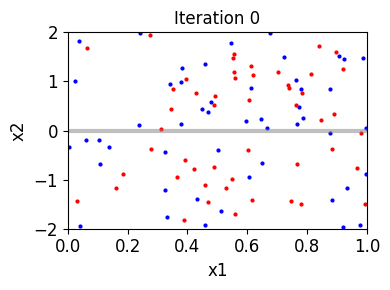

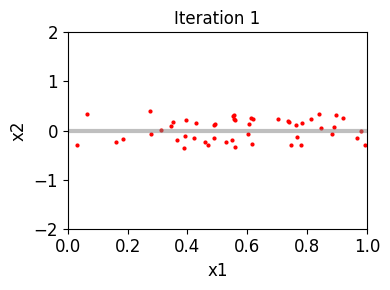

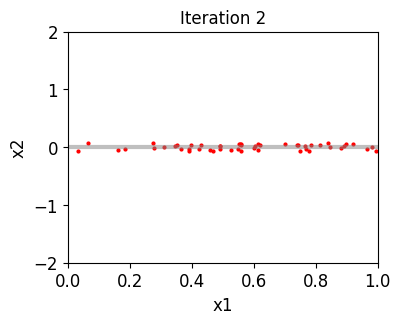

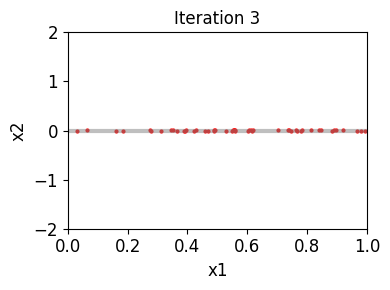

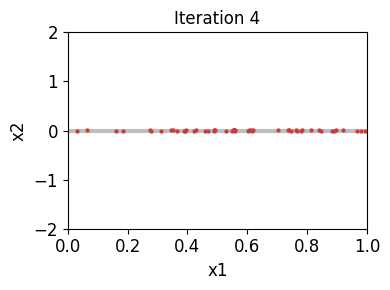

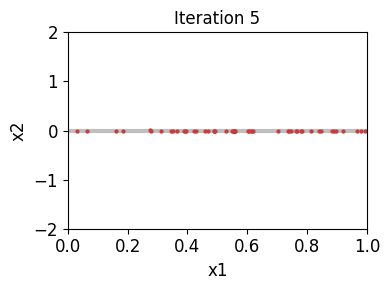

In [12]:
# Iteration 0, with randomly sampled points
figt0 = plt.figure(figsize=(4,3))
ax0 = figt0.add_subplot(111)
ax0.set_xlabel('x1',fontsize=12)
ax0.set_ylabel('x2',fontsize=12)
ax0.scatter(fixed_data[:,0],fixed_data[:,1],c='b', marker='o',s=4)
ax0.plot([1,0],[0,0],c='grey',linewidth=3, alpha=0.5)
ax0.scatter(tres[0][:,0],tres[0][:,1],c='r', marker='o',s=4)
ax0.tick_params(axis='both', which='major', labelsize=12)
ax0.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0,1])
plt.ylim([-2,2])
plt.title('Iteration 0')
figt0.tight_layout()

# Iteration 1, movement of Pareto candidates
figt1 = plt.figure(figsize=(4,3))
ax1 = figt1.add_subplot(111)
ax1.set_xlabel('x1',fontsize=12)
ax1.set_ylabel('x2',fontsize=12)
# ax1.scatter(train_data[:,0],train_data[:,1],c='b', marker='o',s=4)
ax1.plot([1,0],[0,0],c='grey',linewidth=3, alpha=0.5)
ax1.scatter(tres[1][:,0],tres[1][:,1],c='r', marker='o',s=4)
ax1.tick_params(axis='both', which='major', labelsize=12)
ax1.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0,1])
plt.ylim([-2,2])
plt.title('Iteration 1')
figt1.tight_layout()

# Iteration 2
figt2 = plt.figure(figsize=(4,3))
ax2 = figt2.add_subplot(111)
ax2.set_xlabel('x1',fontsize=12)
ax2.set_ylabel('x2',fontsize=12)
# ax2.scatter(train_data[:,0],train_data[:,1],c='b', marker='o',s=4)
ax2.plot([1,0],[0,0],c='grey',linewidth=3, alpha=0.5)
ax2.scatter(tres[2][:,0],tres[2][:,1],c='r', marker='o',s=4)
ax2.tick_params(axis='both', which='major', labelsize=12)
ax2.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0,1])
plt.ylim([-2,2])
plt.title('Iteration 2')
figt1.tight_layout()

# Iteration 3
figt3 = plt.figure(figsize=(4,3))
ax3 = figt3.add_subplot(111)
ax3.set_xlabel('x1',fontsize=12)
ax3.set_ylabel('x2',fontsize=12)
# ax3.scatter(train_data[:,0],train_data[:,1],c='b', marker='o',s=4)
ax3.plot([1,0],[0,0],c='grey',linewidth=3, alpha=0.5)
ax3.scatter(tres[3][:,0],tres[3][:,1],c='r', marker='o',s=4)
ax3.tick_params(axis='both', which='major', labelsize=12)
ax3.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0,1])
plt.ylim([-2,2])
plt.title('Iteration 3')
figt3.tight_layout()

# Iteration 4
figt4 = plt.figure(figsize=(4,3))
ax4 = figt4.add_subplot(111)
ax4.set_xlabel('x1',fontsize=12)
ax4.set_ylabel('x2',fontsize=12)
# ax4.scatter(train_data[:,0],train_data[:,1],c='b', marker='o',s=4)
ax4.plot([1,0],[0,0],c='grey',linewidth=3, alpha=0.5)
ax4.scatter(tres[4][:,0],tres[4][:,1],c='r', marker='o',s=4)
ax4.tick_params(axis='both', which='major', labelsize=12)
ax4.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0,1])
plt.ylim([-2,2])
plt.title('Iteration 4')
figt4.tight_layout()

# Iteration 5
figt5 = plt.figure(figsize=(4,3))
ax5 = figt5.add_subplot(111)
ax5.set_xlabel('x1',fontsize=12)
ax5.set_ylabel('x2',fontsize=12)
# ax5.scatter(train_data[:,0],train_data[:,1],c='b', marker='o',s=4)
ax5.plot([1,0],[0,0],c='grey',linewidth=3, alpha=0.5)
ax5.scatter(tres[5][:,0],tres[5][:,1],c='r', marker='o',s=4)
ax5.tick_params(axis='both', which='major', labelsize=12)
ax5.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0,1])
plt.ylim([-2,2])
plt.title('Iteration 5')
figt5.tight_layout()

In [11]:
'''
error between true vs. approximated manifold over iterations
with each ieration, the Pareto candidates move closer to the true
Manifold, guided by the FJC crieteria, and error decreases
'''

def mse(x):
    # print(x.shape)
    err = np.sum(np.square(x[:,1]-0))/50.
    print(f'{err}')


mse(tres[0])
mse(tres[1])
mse(tres[2])
mse(tres[3])
mse(tres[4])
mse(tres[5])

1.235084795650594
0.04940338134765625
0.0019761350750923156
7.904538884758949e-05
3.1618151115253568e-06
1.2647260518861004e-07
